# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

## Data Processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

## Data Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

## Machine Learning Algos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb

##
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, multilabel_confusion_matrix, classification_report

# Import Data

In [2]:
df = pd.read_pickle("model_df.pkl")
df.head()

,pitch_type,game_date,player_name,batter,pitcher,events,description,zone,game_type,stand,...,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,bin_pitches,count,game_pitcher_id,prev_pitch_type,prev_pitch_bin,platoon
0,SL,2018-10-28,Chris Sale,592518.0,519242.0,strikeout,swinging_strike,13.0,W,R,...,1.0,5.0,Standard,Standard,1,1.0-2.0,563411.0_519242.0,NaN,NaN,1
1,FF,2018-10-28,Chris Sale,592518.0,519242.0,NaN,ball,12.0,W,R,...,1.0,5.0,Standard,Standard,2,0.0-2.0,563411.0_519242.0,SL,1.0,1
2,FF,2018-10-28,Chris Sale,592518.0,519242.0,NaN,foul,3.0,W,R,...,1.0,5.0,Standard,Standard,2,0.0-1.0,563411.0_519242.0,FF,2.0,1
3,CH,2018-10-28,Chris Sale,592518.0,519242.0,NaN,swinging_strike,13.0,W,R,...,1.0,5.0,Standard,Standard,0,0.0-0.0,563411.0_519242.0,FF,2.0,1
4,SL,2018-10-28,Chris Sale,571771.0,519242.0,strikeout,swinging_strike,4.0,W,R,...,1.0,5.0,Standard,Standard,1,3.0-2.0,563411.0_519242.0,CH,0.0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1467510 entries, 0 to 1474089
Data columns (total 42 columns):
pitch_type               1467510 non-null object
game_date                1467510 non-null datetime64[ns]
player_name              1467510 non-null object
batter                   1467510 non-null float64
pitcher                  1467510 non-null float64
events                   374061 non-null object
description              1467510 non-null object
zone                     1465568 non-null float64
game_type                1467510 non-null object
stand                    1467510 non-null object
p_throws                 1467510 non-null object
home_team                1467510 non-null object
away_team                1467510 non-null object
type                     1467510 non-null object
hit_location             326335 non-null float64
bb_type                  254128 non-null object
balls                    1467510 non-null float64
strikes                  1467510 non-null fl

In [4]:
df.shape

(1467510, 42)

In [5]:
df.drop(['events', 'description', 'zone', 'game_type', 
        'type', 'hit_location', 'bb_type', 'game_year', 
        'fielder_2', 'sv_id', 'if_fielding_alignment', 
         'of_fielding_alignment', 'game_pitcher_id'], axis=1, inplace=True)

In [6]:
df['on_1b'] = df['on_1b'].apply(lambda x: not np.isnan(x))
df['on_2b'] = df['on_2b'].apply(lambda x: not np.isnan(x))
df['on_3b'] = df['on_3b'].apply(lambda x: not np.isnan(x))

In [7]:
df['on_3b'].value_counts()

False    1332074
True      135436
Name: on_3b, dtype: int64

In [8]:
df['on_1b'] = df['on_1b'].astype(int)
df['on_2b'] = df['on_2b'].astype(int)
df['on_3b'] = df['on_3b'].astype(int)

In [9]:
df['on_3b'].value_counts()

0    1332074
1     135436
Name: on_3b, dtype: int64

In [10]:
bin_df = df.drop(['pitch_type', 'pitch_name'], axis=1)

In [11]:
bin_df = bin_df.dropna(how='any', axis=0)

In [12]:
bin_df.shape

(1424311, 27)

In [13]:
model_df = pd.get_dummies(bin_df, columns=['count'], prefix = ['count'])

In [14]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1424311 entries, 1 to 1474089
Data columns (total 38 columns):
game_date          1424311 non-null datetime64[ns]
player_name        1424311 non-null object
batter             1424311 non-null float64
pitcher            1424311 non-null float64
stand              1424311 non-null object
p_throws           1424311 non-null object
home_team          1424311 non-null object
away_team          1424311 non-null object
balls              1424311 non-null float64
strikes            1424311 non-null float64
on_3b              1424311 non-null int64
on_2b              1424311 non-null int64
on_1b              1424311 non-null int64
outs_when_up       1424311 non-null float64
inning             1424311 non-null float64
inning_topbot      1424311 non-null object
at_bat_number      1424311 non-null float64
pitch_number       1424311 non-null float64
home_score         1424311 non-null float64
away_score         1424311 non-null float64
bat_score   

# Train-Test Split


In [15]:
features = model_df.drop(['bin_pitches', 'player_name', 'game_date', 
                       'stand', 'p_throws', 'home_team', 'away_team', 
                        'inning_topbot', 'prev_pitch_type'], axis=1)

X = features
y = model_df['bin_pitches']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [16]:
X_train.shape, y_train.shape, X_test.shape

((997017, 29), (997017,), (427294, 29))

## Prepare Data

# prepare input data
def prepare_inputs(X_train, X_test):
	ohe = OneHotEncoder(handle_unknown='ignore')
	ohe.fit(X_train)
	X_train_enc = ohe.transform(X_train)
	X_test_enc = ohe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

X_train_enc.shape

### Reduce memory usage


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

reduce_mem_usage(X_train)

# Vanilla Models

### Logistic Regression

In [17]:
%%time

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_hat_train_log = logreg.predict(X_train)

/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 5.43 s, sys: 689 ms, total: 6.12 s
Wall time: 6.27 s


In [18]:
log_acc = accuracy_score(y_train, y_hat_train_log)
log_pre = precision_score(y_train, y_hat_train_log, average='micro')
log_rec = recall_score(y_train, y_hat_train_log, average='macro')
log_f1 = f1_score(y_train, y_hat_train_log, average='weighted')

print(f'Accuracy: {log_acc}')
print(f'Precision: {log_pre}')
print(f'Recall: {log_rec}')
print(f'F1: {log_f1}')

Accuracy: 0.5959246432106975
Precision: 0.5959246432106975
Recall: 0.3333333333333333
F1: 0.445041289257055


/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
log_cv = np.mean(cross_val_score(logreg, X_train, y_train, cv=5))
print('CV5: ', log_cv)

/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "t

CV5:  0.5959246432221785


### Gaussian Naive Bayes

In [20]:
%%time

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_hat_train_gnb = gaussian.predict(X_train)

CPU times: user 1.77 s, sys: 1.05 s, total: 2.82 s
Wall time: 2.88 s


In [21]:
gnb_acc = accuracy_score(y_train, y_hat_train_gnb)
gnb_pre = precision_score(y_train, y_hat_train_gnb, average='micro')
gnb_rec = recall_score(y_train, y_hat_train_gnb, average='macro')
gnb_f1 = f1_score(y_train, y_hat_train_gnb, average='weighted')

print(f'Accuracy: {gnb_acc}')
print(f'Precision: {gnb_pre}')
print(f'Recall: {gnb_rec}')
print(f'F1: {gnb_f1}')

Accuracy: 0.5959246432106975
Precision: 0.5959246432106975
Recall: 0.3333333333333333
F1: 0.445041289257055


/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
gnb_cv = np.mean(cross_val_score(gaussian, X_train, y_train, cv=5))
print('CV5: ', gnb_cv)

CV5:  0.5959246432221785


### Random Forest

In [23]:
%%time

random_forest = RandomForestClassifier(n_estimators=5)
random_forest.fit(X_train, y_train)
y_hat_train_rf = random_forest.predict(X_train)

CPU times: user 37.2 s, sys: 739 ms, total: 38 s
Wall time: 38.1 s


In [24]:
rf_acc = accuracy_score(y_train, y_hat_train_rf)
rf_pre = precision_score(y_train, y_hat_train_rf, average='micro')
rf_rec = recall_score(y_train, y_hat_train_rf, average='macro')
rf_f1 = f1_score(y_train, y_hat_train_rf, average='weighted')

print(f'Accuracy: {rf_acc}')
print(f'Precision: {rf_pre}')
print(f'Recall: {rf_rec}')
print(f'F1: {rf_f1}')

Accuracy: 0.9470791370658674
Precision: 0.9470791370658674
Recall: 0.9332180614494612
F1: 0.9469436093542922


In [25]:
rf_cv = np.mean(cross_val_score(random_forest, X_train, y_train, cv=5))
print('CV5: ', rf_cv)

CV5:  0.5082691659988157


### XG Boost

In [26]:
%%time

xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)
y_hat_train_xgb = xgb.predict(X_train)

CPU times: user 11min 56s, sys: 2.86 s, total: 11min 58s
Wall time: 12min 3s


In [27]:
xgb_acc = accuracy_score(y_train, y_hat_train_xgb)
xgb_pre = precision_score(y_train, y_hat_train_xgb, average='micro')
xgb_rec = recall_score(y_train, y_hat_train_xgb, average='macro')
xgb_f1 = f1_score(y_train, y_hat_train_xgb, average='weighted')

print(f'Accuracy: {xgb_acc}')
print(f'Precision: {xgb_pre}')
print(f'Recall: {xgb_rec}')
print(f'F1: {xgb_f1}')

Accuracy: 0.5976317354668977
Precision: 0.5976317354668977
Recall: 0.3394470846107372
F1: 0.45932861318790547


In [28]:
# xgb_cv = np.mean(cross_val_score(xgb, X_train, y_train, cv=5))
# print('CV5: ', xgb_cv)

KeyboardInterrupt: 

### AdaBoost

In [29]:
%%time

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_hat_train_ada = ada.predict(X_train)

CPU times: user 2min 58s, sys: 8 s, total: 3min 6s
Wall time: 3min 8s


In [30]:
ada_acc = accuracy_score(y_train, y_hat_train_ada)
ada_pre = precision_score(y_train, y_hat_train_ada, average='micro')
ada_rec = recall_score(y_train, y_hat_train_ada, average='macro')
ada_f1 = f1_score(y_train, y_hat_train_ada, average='weighted')

print(f'Accuracy: {ada_acc}')
print(f'Precision: {ada_pre}')
print(f'Recall: {ada_rec}')
print(f'F1: {ada_f1}')

Accuracy: 0.5925656232541672
Precision: 0.5925656232541672
Recall: 0.34653131795052
F1: 0.4734150986941854


In [ ]:
# ada_cv = np.mean(cross_val_score(ada, X_train, y_train, cv=5))
# print('CV5: ', ada_cv)

### K-nearest Neighbors

In [31]:
%%time

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_hat_train_knn = knn.predict(X_train)

CPU times: user 1min 18s, sys: 1.22 s, total: 1min 20s
Wall time: 1min 20s


In [32]:
knn_acc = accuracy_score(y_train, y_hat_train_knn)
knn_pre = precision_score(y_train, y_hat_train_knn, average='micro')
knn_rec = recall_score(y_train, y_hat_train_knn, average='macro')
knn_f1 = f1_score(y_train, y_hat_train_knn, average='weighted')

print(f'Accuracy: {knn_acc}')
print(f'Precision: {knn_pre}')
print(f'Recall: {knn_rec}')
print(f'F1: {knn_f1}')

Accuracy: 0.6897866335278134
Precision: 0.6897866335278134
Recall: 0.6026669276369555
F1: 0.6843264160790075


In [ ]:
# knn_cv = np.mean(cross_val_score(knn, X_train, y_train, cv=5))
# print('CV5: ', knn_cv)

### Compare Vanilla Models

In [33]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 
              'AdaBoost', 'XG Boost', 'KNN'], 
    'Accuracy': [log_acc, gnb_acc, rf_acc, ada_acc, 
             xgb_acc, knn_acc], 
    'Precision': [log_pre, gnb_pre, rf_pre, ada_pre, 
             xgb_pre, knn_pre], 
    'F1 Score': [log_f1, gnb_f1, rf_f1, ada_f1, 
             xgb_f1, knn_f1]}) 
#    'CV': [log_cv, gnb_cv, rf_cv, ada_cv, 
#             xgb_cv, knn_cv]})
models.sort_values(by='Precision', ascending=False)

,Model,Accuracy,Precision,F1 Score
2,Random Forest,0.947079,0.947079,0.946944
5,KNN,0.689787,0.689787,0.684326
4,XG Boost,0.597632,0.597632,0.459329
0,Logistic Regression,0.595925,0.595925,0.445041
1,Naive Bayes,0.595925,0.595925,0.445041
3,AdaBoost,0.592566,0.592566,0.473415


In [34]:
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,F1 Score
2,Random Forest,0.947079,0.947079,0.946944
5,KNN,0.689787,0.689787,0.684326
4,XG Boost,0.597632,0.597632,0.459329
0,Logistic Regression,0.595925,0.595925,0.445041
1,Naive Bayes,0.595925,0.595925,0.445041
3,AdaBoost,0.592566,0.592566,0.473415


In [ ]:
# models.sort_values(by='CV', ascending=False)

### Random Forest Feature Importance

In [35]:
feature_df = pd.DataFrame(random_forest.feature_importances_, index=X_train.columns)

In [36]:
feature_df.rename({0:'Score'}, axis=1, inplace=True)

In [37]:
feature_df = feature_df.sort_values(by='Score', ascending=False)

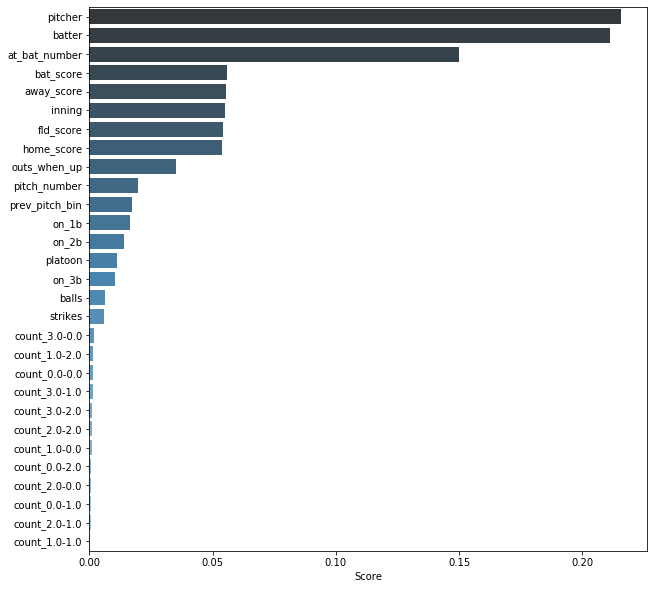

In [38]:
plt.figure(figsize=(10,10))
sns.barplot(x='Score', y=feature_df.index, data=feature_df, orient='h', palette='Blues_d');

### Confusion Matrix

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

Confusion matrix, without normalization
[[111777   2317   8239]
 [  3632 257673  19232]
 [  5431  13912 574804]]


(2.5, -0.5)

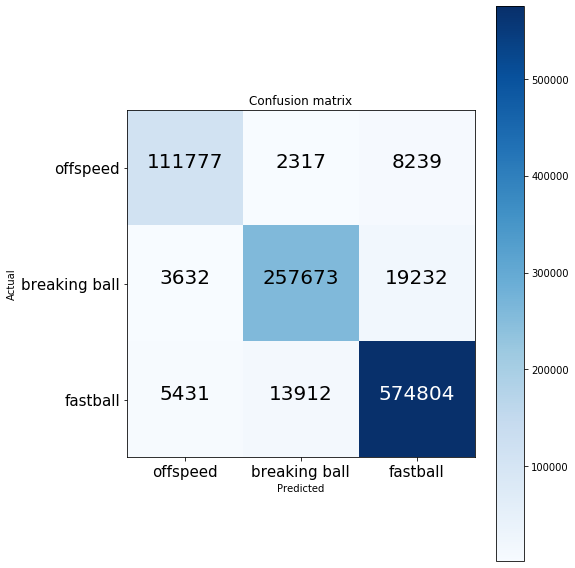

In [40]:
cnf_matrix = confusion_matrix(y_train, y_hat_train_rf,labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['offspeed', 'breaking ball', 'fastball'])
plt.ylim(len(cnf_matrix)-0.5,-0.5)

## Paremeter Tuning

In [50]:
%%time

rf_weight = RandomForestClassifier()

rf_params = {
    'n_estimators': [10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10], 
    'n_jobs': [-1]
}

rf_grid = GridSearchCV(estimator=rf_weight, 
                          param_grid=rf_params, 
                          scoring='accuracy', 
                          cv=5)

rf_grid.fit(X_train, y_train)
# rf_grid.score(X_test, y_test)

CPU times: user 7min 38s, sys: 25min 52s, total: 33min 31s
Wall time: 1h 6min 50s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [51]:
rf_grid.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 10, 'n_jobs': -1}

# Final Model

In [83]:
%%time

final_random_forest = RandomForestClassifier(criterion= 'entropy', max_depth= 10, 
                                       n_estimators= 5, n_jobs= -1, class_weight= 'balanced')
final_random_forest.fit(X_train, y_train)
y_hat_test_rf = final_random_forest.predict(X_test)

CPU times: user 27.5 s, sys: 776 ms, total: 28.3 s
Wall time: 12 s


In [84]:
rf_acc = accuracy_score(y_test, y_hat_test_rf)
rf_pre = precision_score(y_test, y_hat_test_rf, average='micro')
rf_rec = recall_score(y_test, y_hat_test_rf, average='macro')
rf_f1 = f1_score(y_test, y_hat_test_rf, average='weighted')

print(f'Accuracy: {rf_acc}')
print(f'Precision: {rf_pre}')
print(f'Recall: {rf_rec}')
print(f'F1: {rf_f1}')

Accuracy: 0.395278192532542
Precision: 0.395278192532542
Recall: 0.4882566705212305
F1: 0.4103668401134553


In [78]:
rf_cv = np.mean(cross_val_score(final_random_forest, X_test, y_test, cv=5))
print('CV5: ', rf_cv)

CV5:  0.3915664664575097


### Feature Importance

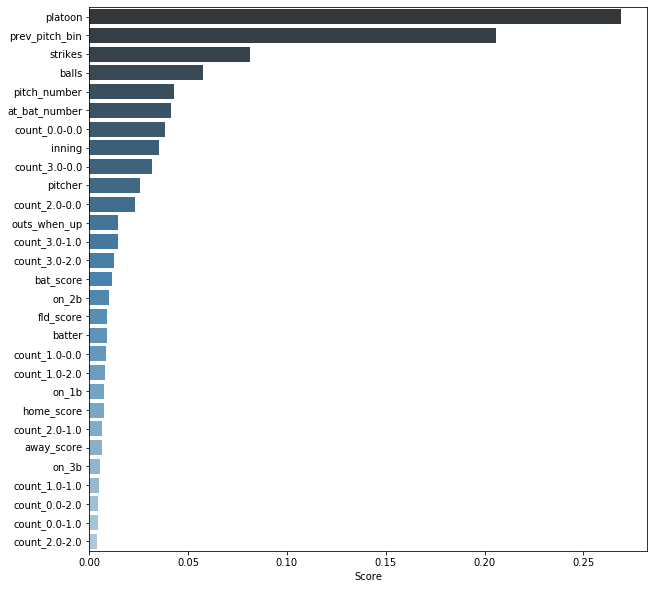

In [75]:
final_feature_df = pd.DataFrame(final_random_forest.feature_importances_, index=X_train.columns)
final_feature_df.rename({0:'Score'}, axis=1, inplace=True)
final_feature_df.sort_values(by='Score', ascending=False, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(x='Score', y=final_feature_df.index, data=final_feature_df, orient='h', palette='Blues_d');

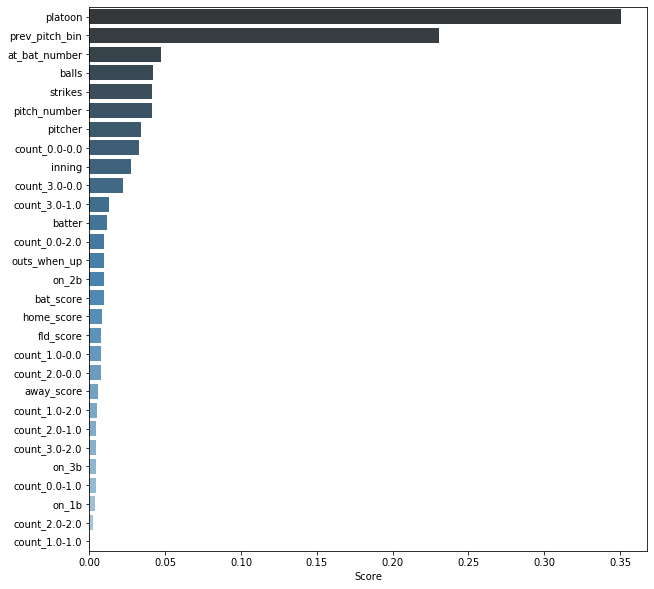

In [79]:
final_feature_df = pd.DataFrame(final_random_forest.feature_importances_, index=X_train.columns)
final_feature_df.rename({0:'Score'}, axis=1, inplace=True)
final_feature_df.sort_values(by='Score', ascending=False, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(x='Score', y=final_feature_df.index, data=final_feature_df, orient='h', palette='Blues_d');

### Confusion Matrix

Confusion matrix, without normalization
[[    88     22  51889]
 [    16    190 120722]
 [   100    153 254114]]


(2.5, -0.5)

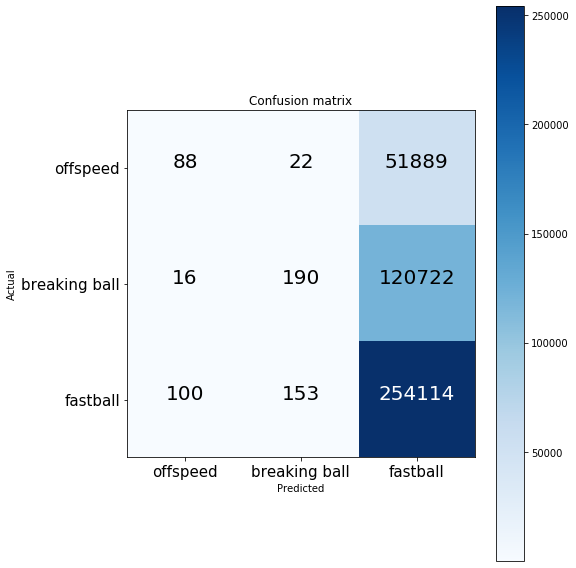

In [63]:
# Function from above
cnf_matrix = confusion_matrix(y_test, y_hat_test_rf,labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['offspeed', 'breaking ball', 'fastball'])
plt.ylim(len(cnf_matrix)-0.5,-0.5)

Confusion matrix, without normalization
[[35086 10990  5923]
 [39782 62526 18620]
 [93903 90786 69678]]


(2.5, -0.5)

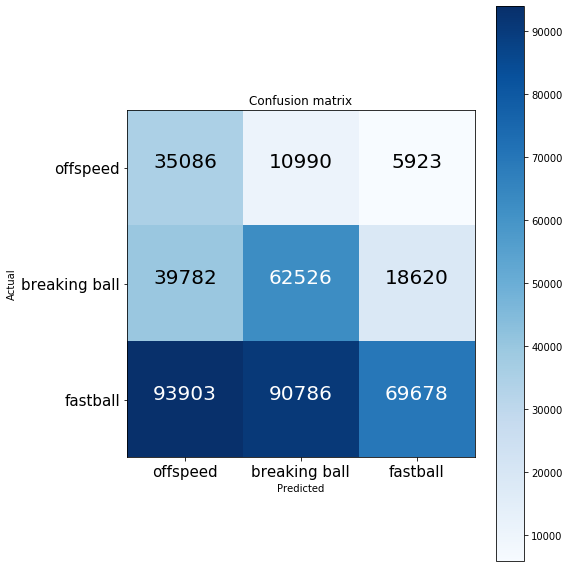

In [80]:
# Function from above
cnf_matrix = confusion_matrix(y_test, y_hat_test_rf,labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['offspeed', 'breaking ball', 'fastball'])
plt.ylim(len(cnf_matrix)-0.5,-0.5)

## Pitcher Models

In [41]:
X = model_df[model_df['player_name']=='Patrick Corbin'].drop(
    ['bin_pitches', 'player_name', 'game_date', 'stand', 'p_throws', 
     'home_team', 'away_team', 'inning_topbot', 'prev_pitch_type'], axis=1)
y = model_df[model_df['player_name']=='Patrick Corbin']['bin_pitches']
X_train_corbin, X_test_corbin, y_train_corbin, y_test_corbin = train_test_split(X, y, test_size=0.3, random_state=22)

In [64]:
X_train_corbin.shape, y_train_corbin.shape, X_test_corbin.shape

((4749, 29), (4749,), (2036, 29))

In [43]:
%%time

random_forest = RandomForestClassifier(n_estimators=5)
random_forest.fit(X_train_corbin, y_train_corbin)
y_hat_train_rf_corbin = random_forest.predict(X_train_corbin)

CPU times: user 58.2 ms, sys: 34.7 ms, total: 92.9 ms
Wall time: 91.9 ms


In [44]:
corbin_rf_acc = accuracy_score(y_train_corbin, y_hat_train_rf_corbin)
corbin_rf_pre = precision_score(y_train_corbin, y_hat_train_rf_corbin, average='micro')
corbin_rf_rec = recall_score(y_train_corbin, y_hat_train_rf_corbin, average='macro')
corbin_rf_f1 = f1_score(y_train_corbin, y_hat_train_rf_corbin, average='weighted')

print(f'Accuracy: {corbin_rf_acc}')
print(f'Precision: {corbin_rf_pre}')
print(f'Recall: {corbin_rf_rec}')
print(f'F1: {corbin_rf_f1}')

Accuracy: 0.9460939145083176
Precision: 0.9460939145083176
Recall: 0.9307244947586978
F1: 0.9460692075408986


In [45]:
corbin_rf_cv = np.mean(cross_val_score(random_forest, X_train_corbin, y_train_corbin, cv=5))
print('CV5: ', corbin_rf_cv)

CV5:  0.5209444090698966


In [46]:
corbin_feature_df = pd.DataFrame(random_forest.feature_importances_, index=X_train_corbin.columns)

In [47]:
corbin_feature_df.rename({0:'Score'}, axis=1, inplace=True)

In [48]:
corbin_feature_df = corbin_feature_df.sort_values(by='Score', ascending=False)

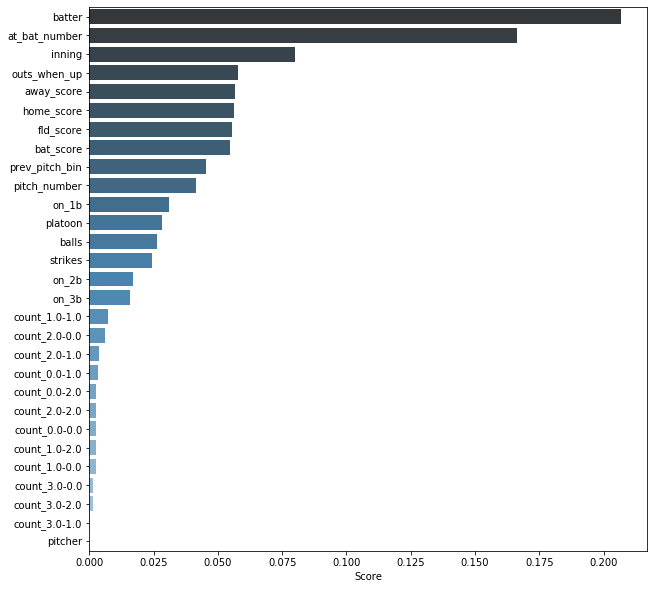

In [49]:
plt.figure(figsize=(10,10))
sns.barplot(x='Score', y=corbin_feature_df.index, data=corbin_feature_df, orient='h', palette='Blues_d');

## Final Pitcher Model

In [66]:
%%time

fp_random_forest = RandomForestClassifier(criterion= 'entropy', max_depth= 10, 
                                       n_estimators= 5, n_jobs= -1)
fp_random_forest.fit(X_train_corbin, y_train_corbin)
y_hat_test_corbin = fp_random_forest.predict(X_test_corbin)

CPU times: user 54.8 ms, sys: 12.7 ms, total: 67.5 ms
Wall time: 230 ms


In [67]:
rf_acc = accuracy_score(y_test_corbin, y_hat_test_corbin)
rf_pre = precision_score(y_test_corbin, y_hat_test_corbin, average='micro')
rf_rec = recall_score(y_test_corbin, y_hat_test_corbin, average='macro')
rf_f1 = f1_score(y_test_corbin, y_hat_test_corbin, average='weighted')

print(f'Accuracy: {rf_acc}')
print(f'Precision: {rf_pre}')
print(f'Recall: {rf_rec}')
print(f'F1: {rf_f1}')

Accuracy: 0.5618860510805501
Precision: 0.5618860510805501
Recall: 0.37949253622153156
F1: 0.5430273806888821


/Users/jefflindberg/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
corbin_rf_cv = np.mean(cross_val_score(fp_random_forest, X_test_corbin, y_test_corbin, cv=5))
print('CV5: ', corbin_rf_cv)

CV5:  0.5329252390611418


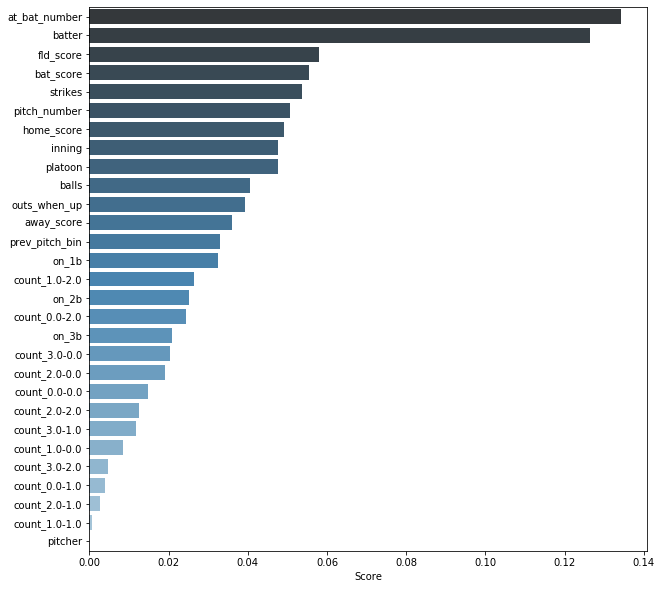

In [69]:
fp_feature_df = pd.DataFrame(fp_random_forest.feature_importances_, index=X_train_corbin.columns)
fp_feature_df.rename({0:'Score'}, axis=1, inplace=True)
fp_feature_df.sort_values(by='Score', ascending=False, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(x='Score', y=fp_feature_df.index, data=fp_feature_df, orient='h', palette='Blues_d');

Confusion matrix, without normalization
[[  0  15  50]
 [  0 381 532]
 [  0 295 763]]


(2.5, -0.5)

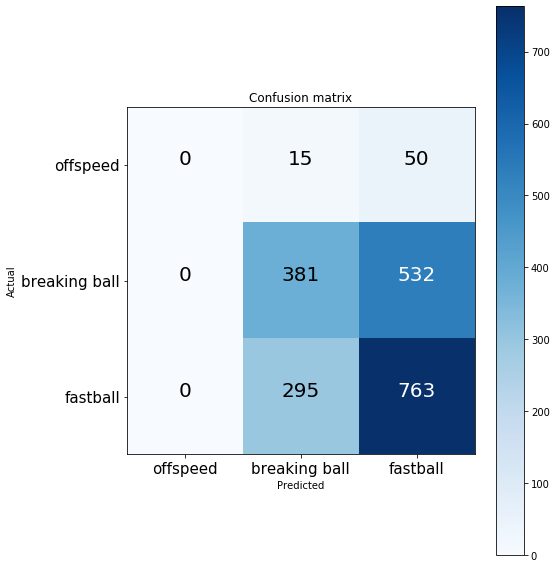

In [70]:
# Function from above
cnf_matrix = confusion_matrix(y_test_corbin, y_hat_test_corbin,labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['offspeed', 'breaking ball', 'fastball'])
plt.ylim(len(cnf_matrix)-0.5,-0.5)